# **Molecular design via diffusion models**

Diffusion models are a super popular (_and recent_) alternative for generative models. In this case, we will employ one of the first models to make use of diffusion-denoising processes to generate molecules. In this case, molecules will be considered as a collecion of points in 3D space, with the type of atom and other features as extra information in each node. 

This notebook will serve as a guide to some parts of the main code, although if you want to get into it in more depth you can either study the files here present or visit the original [github repository](https://github.com/ehoogeboom/e3_diffusion_for_molecules). 

<center>
<img src='https://drive.google.com/uc?id=12_jdajW2xHFgIL3tSNpm6qwd9digckHE'>
</center>

We will divide the present notebook into four separate sections to showcase the method: 

1. Loading and visualizing 3D molecules from **QM9**

2. Testing the stability for one molecule

3. Showing the $E(3)$ equivariance of the model

4. **Make a denoising example using a random sample and visualizing the denoising chain**



In [1]:
import os, sys
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
repsol_path = '/content/repsol-ml4md'
your_path = '/content/drive/MyDrive/Proyectos/repsol-ml4md/generative_models/diffusion'
os.symlink(your_path, repsol_path)  # Change your path here wherever you may need it to be

In this instance, the model is already trained. To re-do the training, or train the model in a different dataset, we can follow the instructions present in the original repository. In this case, we will not get into the fine details about it.

As a brief summary of what happens during training, the procedure can be visualized as the following

<center>
<img src='https://drive.google.com/uc?id=1JrZ9BjDlVlN-FusXOHAW70gfl2aMHXO_'>
</center>

The model adds a certain level of noise to the original molecule, to de-noise the outcome. Using this, the function allows for the generation of new molecules using noise as input. The complete information of the dataset will be encoded in the denoising procedure.

In [3]:
generative_model_path = '/content/repsol-ml4md/outputs/edm_qm9'
source_code_path = '/content/repsol-ml4md/source'

sys.path.insert(0, generative_model_path)
sys.path.insert(0, source_code_path)
sys.path.insert(0, repsol_path)

Import the dataset and the relevant packages to run and visualize the results 

In [4]:
# Import the dataset
from qm9 import dataset

from tkinter import *
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import glob
from mpl_toolkits import mplot3d
import argparse
from qm9.models import get_model

import torch
import pickle
from os.path import join
from configs.datasets_config import get_dataset_info
import imageio

import qm9.visualizer as vis
from torch.nn import functional as F

%matplotlib inline

We will use some extra functions to simplify the discussion here. The `get_dataset_info` function imports a dictionary with the specification for the model parameters, as well as extra information that will be useful later on.

In [5]:
dataset_info = get_dataset_info('qm9', False)
dataset_info # To show how it looks

{'name': 'qm9',
 'atom_encoder': {'H': 0, 'C': 1, 'N': 2, 'O': 3, 'F': 4},
 'atom_decoder': ['H', 'C', 'N', 'O', 'F'],
 'n_nodes': {22: 3393,
  17: 13025,
  23: 4848,
  21: 9970,
  19: 13832,
  20: 9482,
  16: 10644,
  13: 3060,
  15: 7796,
  25: 1506,
  18: 13364,
  12: 1689,
  11: 807,
  24: 539,
  14: 5136,
  26: 48,
  7: 16,
  10: 362,
  8: 49,
  9: 124,
  27: 266,
  4: 4,
  29: 25,
  6: 9,
  5: 5,
  3: 1},
 'max_n_nodes': 29,
 'atom_types': {1: 635559, 2: 101476, 0: 923537, 3: 140202, 4: 2323},
 'distances': [903054,
  307308,
  111994,
  57474,
  40384,
  29170,
  47152,
  414344,
  2202212,
  573726,
  1490786,
  2970978,
  756818,
  969276,
  489242,
  1265402,
  4587994,
  3187130,
  2454868,
  2647422,
  2098884,
  2001974,
  1625206,
  1754172,
  1620830,
  1710042,
  2133746,
  1852492,
  1415318,
  1421064,
  1223156,
  1322256,
  1380656,
  1239244,
  1084358,
  981076,
  896904,
  762008,
  659298,
  604676,
  523580,
  437464,
  413974,
  352372,
  291886,
  271948,
  2

In [6]:
# Select a device to run the code (ready for CUDA)
device = torch.device("cuda")
device = torch.device('cpu')
dtype = torch.float32

### Arguments

In this model, we need to specify a lot of parameters. In order to simplify further the notation in the rest of the notebook, we will employ a `class` here so that we can load the needed parameters at any other point in the code.

In [7]:
class args:
    actnorm=True 
    aggregation_method='sum'                        # How to add the noise
    attention=True                                  # Use attention modules
    augment_noise=0
    batch_size=1                                    # Batch size
    break_train_epoch=False 
    brute_force=False 
    clip_grad=True
    condition_time=True 
    conditioning=[]                                 # Arguments : homo | lumo | alpha | gap | mu | Cv
    context_node_nf=0 
    cuda=False                                      # Avoid GPU run here
    current_epoch=1001 
    data_augmentation=False 
    datadir='qm9/temp'                              # Database info
    dataset='qm9'                                   # Data name
    dequantization='argmax_variational'
    device='cpu'                                    # CPU or GPU
    diffusion_loss_type='l2'                        # Loss for the denoising steps
    diffusion_noise_precision=1e-05                 # Noise precision
    diffusion_noise_schedule='polynomial_2' 
    diffusion_steps=1000                            # Diffusion steps
    dp=True 
    ema_decay=0.9999 
    exp_name='polynomial_2_final_0' 
    filter_n_atoms=None                             # Filter certain atom types
    generate_epochs=1 
    include_charges=True                            # Use atom charge information or not
    inv_sublayers=1 
    lr=0.0001 
    model='egnn_dynamics'                           # Pre-constructed model structure
    n_epochs=3000                                   # Training epochs
    n_layers=9                                      # NN layers
    n_report_steps=1          
    n_stability_samples=1000                        # Number of samples to compute the stability
    nf=256                                          # Size of layers
    no_cuda=False 
    no_wandb=False 
    norm_constant=1 
    normalization_factor=1 
    normalize_factors=[1, 4, 10] 
    num_workers=0 
    ode_regularization=0.001 
    online=True 
    probabilistic_model='diffusion' 
    remove_h=False 
    resume=None 
    save_model=True                                # Save the model once training is done
    sin_embedding=False 
    start_epoch=0 
    tanh=True 
    test_epochs=20        
    trace='hutch' 
    visualize_every_batch=1e8                      # Can be used to visualize multiple times per epoch 
    wandb_usr=None                                 # User to use the WANDB condtrol
    model_path=f'{repsol_path}/outputs/edm_qm9'    # Path to model 
    
args = args()

We also have the two lists that will serve to **encode** and **decode** all atom types present in our database

In [8]:
dataset_info['atom_encoder']

{'H': 0, 'C': 1, 'N': 2, 'O': 3, 'F': 4}

In [9]:
dataset_info['atom_decoder']

['H', 'C', 'N', 'O', 'F']

Retrieve dataloaders for the QM9 dataset (_the database is big, this may take a while..._)

In [10]:
dataloaders, charge_scale = dataset.retrieve_dataloaders(args)

dict_keys([0, 1, 6, 7, 8, 9])
dict_keys([0, 1, 6, 7, 8, 9])
dict_keys([0, 1, 6, 7, 8, 9])


# **Visualization of QM9 molecules** 
### Tools for visualizing molecules in the model
For each molecule in the dataset, we will have a corresponding graph. Each of these graphs is said to be _complete_, in the sense that every node is connected to every other node and the configuration of atoms is based on the geometric positions and distances between them. However, as one may expect, this is missing the _bond type_ information that we may need to fully describe molecules. The decision for assigining one type of bond over another in each molecule is based on the dictionaries below, where we define the distances between each possible pair of atoms. 

In [11]:
# Bond distance for every type of bond

# Single
bonds1 = {'H': {'H': 74, 'C': 109, 'N': 101, 'O': 96, 'F': 92, 'B': 119, 'Si': 148, 'P': 144, 'As': 152, 'S': 134, 'Cl': 127, 'Br': 141, 'I': 161},
          'C': {'H': 109, 'C': 154, 'N': 147, 'O': 143, 'F': 135, 'Si': 185, 'P': 184, 'S': 182, 'Cl': 177, 'Br': 194, 'I': 214},
          'N': {'H': 101, 'C': 147, 'N': 145, 'O': 140, 'F': 136, 'Cl': 175, 'Br': 214, 'S': 168, 'I': 222, 'P': 177}, 
          'O': {'H': 96, 'C': 143, 'N': 140, 'O': 148, 'F': 142, 'Br': 172, 'S': 151, 'P': 163, 'Si': 163, 'Cl': 164, 'I': 194},
          'F': {'H': 92, 'C': 135, 'N': 136, 'O': 142, 'F': 142, 'S': 158, 'Si': 160, 'Cl': 166, 'Br': 178, 'P': 156, 'I': 187},
          'B': {'H':  119, 'Cl': 175},
          'Si': {'Si': 233, 'H': 148, 'C': 185, 'O': 163, 'S': 200, 'F': 160, 'Cl': 202, 'Br': 215, 'I': 243 },
          'Cl': {'Cl': 199, 'H': 127, 'C': 177, 'N': 175, 'O': 164, 'P': 203, 'S': 207, 'B': 175, 'Si': 202, 'F': 166, 'Br': 214},
          'S': {'H': 134, 'C': 182, 'N': 168, 'O': 151, 'S': 204, 'F': 158, 'Cl': 207, 'Br': 225, 'Si': 200, 'P': 210, 'I': 234},
          'Br': {'Br': 228, 'H': 141, 'C': 194, 'O': 172, 'N': 214, 'Si': 215, 'S': 225, 'F': 178, 'Cl': 214, 'P': 222},
          'P': {'P': 221, 'H': 144, 'C': 184, 'O': 163, 'Cl': 203, 'S': 210, 'F': 156, 'N': 177, 'Br': 222},
          'I': {'H': 161, 'C': 214, 'Si': 243, 'N': 222, 'O': 194, 'S': 234, 'F': 187, 'I': 266},
          'As': {'H': 152}
          }

# Double
bonds2 = {'C': {'C': 134, 'N': 129, 'O': 120, 'S': 160},
          'N': {'C': 129, 'N': 125, 'O': 121},
          'O': {'C': 120, 'N': 121, 'O': 121, 'P': 150},
          'P': {'O': 150, 'S': 186},
          'S': {'P': 186}}

# Triple
bonds3 = {'C': {'C': 120, 'N': 116, 'O': 113},
          'N': {'C': 116, 'N': 110},
          'O': {'C': 113}}

# Extra margins to define the bond-distance-limit
margin1 = 10
margin2 = 5
margin3 = 3

# Max. number of bonds per atoms
allowed_bonds = {'H': 1, 'C': 4, 'N': 3, 'O': 2, 'F': 1, 'B': 3, 'Al': 3,
                 'Si': 4, 'P': [3, 5],
                 'S': 4, 'Cl': 1, 'As': 3, 'Br': 1, 'I': 1, 'Hg': [1, 2],
                 'Bi': [3, 5]}

We use the following function to compute whether there is a bond between two atoms in the graph (and if so, of which type).

In [12]:
'''
Core function to predict the bond order given the preious information in the 
dictionaries. In this case, the function is usually called using "geom_predictor"
'''
def get_bond_order(atom1, atom2, distance, check_exists=False):
    distance = 100 * distance  # We change the metric

    # Check exists for large molecules where some atom pairs do not have a
    # typical bond length.
    if check_exists:
        if atom1 not in bonds1:
            return 0
        if atom2 not in bonds1[atom1]:
            return 0

    # margin1, margin2 and margin3 have been tuned to maximize the stability of
    # the QM9 true samples.
    if distance < bonds1[atom1][atom2] + margin1:
        # Check if atoms in bonds2 dictionary.
        if atom1 in bonds2 and atom2 in bonds2[atom1]:
            thr_bond2 = bonds2[atom1][atom2] + margin2
            if distance < thr_bond2:

                # Check again, in this case for bond3
                if atom1 in bonds3 and atom2 in bonds3[atom1]:
                    thr_bond3 = bonds3[atom1][atom2] + margin3
                    if distance < thr_bond3:
                        return 3        # Triple
                return 2            # Double
        return 1                # Single
    return 0                    # No bond


'''
Function to encase the "get_bond_order" and check whether there is a bond or 
not (and if so, which type)
'''
def geom_predictor(p, l, margin1=5, limit_bonds_to_one=False):
    """ p: atom pair (couple of str)
        l: bond length (float)"""
    bond_order = get_bond_order(p[0], p[1], l, check_exists=True)

    # If limit_bonds_to_one is enabled, every bond type will return 1.
    if limit_bonds_to_one:
        return 1 if bond_order > 0 else 0
    else:
        return bond_order

The functions in this next block serve to **render the molecule** and draw the bonds wherever they are deemed to exist functions below render the molecule and draw the bonds when they are deemed to exist. 

In [13]:
def plot_molecule(ax, positions, atom_type, alpha, spheres_3d, hex_bg_color,
                  dataset_info):

    # Extract the positions
    x = positions[:, 0]
    y = positions[:, 1]
    z = positions[:, 2]

    # Color code the atoms
    colors_dic = np.array(dataset_info['colors_dic'])
    radius_dic = np.array(dataset_info['radius_dic'])
    area_dic = 1500 * radius_dic ** 2

    areas = area_dic[atom_type]
    radii = radius_dic[atom_type]
    colors = colors_dic[atom_type]

    # Plot the atoms as spheres
    if spheres_3d:
        for i, j, k, s, c in zip(x, y, z, radii, colors):
            vis.draw_sphere(ax, i.item(), j.item(), k.item(), 0.7 * s, c, alpha)
    else:
        ax.scatter(x, y, z, s=areas, alpha=0.9 * alpha,
                   c=colors)  # , linewidths=2, edgecolors='#FFFFFF')
    
    # Plot the bonds as edges
    for i in range(len(atom_type)):
        for j in range(i+1, len(atom_type)):
            p1 = np.array([x[i], y[i], z[i]])
            p2 = np.array([x[j], y[j], z[j]])
            dist = np.sqrt(np.sum((p1 - p2) ** 2))
            atom1, atom2 = dataset_info['atom_decoder'][atom_type[i]], dataset_info['atom_decoder'][atom_type[j]]
            s = sorted((atom_type[i], atom_type[j]))
            pair = (dataset_info['atom_decoder'][s[0]],
                    dataset_info['atom_decoder'][s[1]])

            if 'qm9' in dataset_info['name']:
                draw_edge_int = get_bond_order(atom1, atom2, dist)
                line_width = (3 - 2) * 2 * 2

            elif dataset_info['name'] == 'geom':
                draw_edge_int = geom_predictor(pair, dist)
                # Draw edge outputs 1 / -1 value, convert to True / False.
                line_width = 2

            else:
                raise Exception('Wrong dataset_info name')

            draw_edge = draw_edge_int > 0

            if draw_edge:

                if draw_edge_int == 4:
                    linewidth_factor = 1.5

                else:
                    linewidth_factor = 1
                ax.plot([x[i], x[j]], [y[i], y[j]], [z[i], z[j]],
                        linewidth=line_width * linewidth_factor,
                        c=hex_bg_color, alpha=alpha)


# Function to frame the molecule plots
def plot_data3d(positions, atom_type, dataset_info, camera_elev=0, camera_azim=0, save_path=None, spheres_3d=False,
                bg='black', alpha=1.):
    
    # Color coding
    black = (0, 0, 0)
    white = (1, 1, 1)
    hex_bg_color = '#FFFFFF' if bg == 'black' else '#666666'

    # 3D plot setup
    from mpl_toolkits.mplot3d import Axes3D
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.set_aspect('auto')
    ax.view_init(elev=camera_elev, azim=camera_azim)
    if bg == 'black':
        ax.set_facecolor(black)
    else:
        ax.set_facecolor(white)
    ax.xaxis.pane.set_alpha(0)
    ax.yaxis.pane.set_alpha(0)
    ax.zaxis.pane.set_alpha(0)
    ax._axis3don = False

    # Background
    if bg == 'black':
        ax.w_xaxis.line.set_color("black")
    else:
        ax.w_xaxis.line.set_color("white")

    print(positions.shape, atom_type)
    plot_molecule(ax, positions, atom_type, alpha, spheres_3d,
                  hex_bg_color, dataset_info)

    # Dataset-dependent setup
    if 'qm9' in dataset_info['name']:
        max_value = positions.abs().max().item()
        axis_lim = min(40, max(max_value / 1.5 + 0.3, 3.2))
        ax.set_xlim(-axis_lim, axis_lim)
        ax.set_ylim(-axis_lim, axis_lim)
        ax.set_zlim(-axis_lim, axis_lim)

    elif dataset_info['name'] == 'geom':
        max_value = positions.abs().max().item()
        axis_lim = min(40, max(max_value / 1.5 + 0.3, 3.2))
        ax.set_xlim(-axis_lim, axis_lim)
        ax.set_ylim(-axis_lim, axis_lim)
        ax.set_zlim(-axis_lim, axis_lim)

    else:
        raise ValueError(dataset_info['name'])

    dpi = 120 if spheres_3d else 50

    # Export, if given a path
    if save_path is not None:
        plt.savefig(save_path, bbox_inches='tight', pad_inches=0.0, dpi=dpi)

        if spheres_3d:
            img = imageio.imread(save_path)
            img_brighter = np.clip(img * 1.4, 0, 255).astype('uint8')
            imageio.imsave(save_path, img_brighter)
            
    else:
        plt.show()
    plt.close()

These functions above can be used to plot a lot of molecules at the same time. However, we can build slightly simpler versions to just render one molecule at a time.

In [14]:
# Load positional values of the molecule and output encoded information for the plot
def load_molecule_xyz_nb(data_dummy, dataset_info):

    n_atoms = int(data_dummy['num_atoms'].numpy()[0])                   # Number of atoms
    one_hot = torch.zeros(n_atoms, len(dataset_info['atom_decoder']))   # One-hot for atom type
    charges = data_dummy['charges'][0]                                  # Atom's charges
    positions =  data_dummy['positions'][0]                             # Atom's positions
    for i in range(n_atoms):
        one_hot[i, (data_dummy['one_hot'][0][i]==True).nonzero().item()] = 1
  
    return positions, one_hot, charges

# Visualize a molecule (simpler version)
def visualize_nb(data_dummy, dataset_info, max_num=25, wandb=None, spheres_3d=True):
    
    # Extract molecular info
    positions, one_hot, charges = load_molecule_xyz_nb(data_dummy, dataset_info)
    atom_type = torch.argmax(one_hot, dim=1).numpy()
    dists = torch.cdist(positions.unsqueeze(0), positions.unsqueeze(0)).squeeze(0)
    dists = dists[dists > 0]

    print("Average distance between atoms", dists.mean().item())
    print(positions.shape, atom_type)
    print(atom_type)

    # Simplified call to the "plot_data3d" function to render the molecule
    plot_data3d(positions, atom_type, 
                dataset_info=dataset_info,
                spheres_3d=spheres_3d)

Select one random example from the dataset and visualize the molecule

Average distance between atoms 3.1601409912109375
torch.Size([17, 3]) [1 1 2 1 1 3 1 2 3 0 0 0 0 0 0 0 0]
[1 1 2 1 1 3 1 2 3 0 0 0 0 0 0 0 0]
torch.Size([17, 3]) [1 1 2 1 1 3 1 2 3 0 0 0 0 0 0 0 0]


<ipython-input-13-e6b20681c140>:89: MatplotlibDeprecationWarning: The w_xaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use xaxis instead.
  ax.w_xaxis.line.set_color("black")


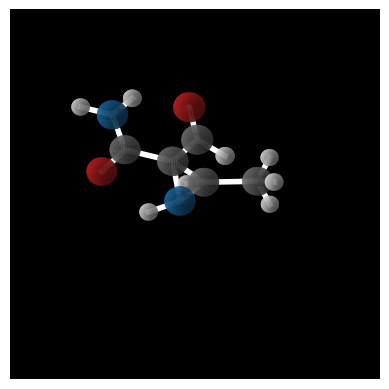

In [15]:
# Call one molecule instance from the database
data_dummy = next(iter(dataloaders['train']))

# Rendering
visualize_nb(data_dummy, dataset_info)

# **Molecule stability**

One major concern with the diffusion model implementation is producing chemically stable molecules, _i.e._ molecules that will in principle "_not fall apart_" or that do not react with other things. Although there is more refinement in the chemical concept of stability, we here refer to a molecule as stable if all of its atoms' bonds are stable. In that sense, it is important that each type of atom has, _at most_, the assigned maximum number of bonds for said type, and that is has no free bonds left. Moreover, there should not be any free bonds for a single atom in the molecule. If these two criteria are met, we call the molecule **stable**. 

Since this is an important point here, we construct the following function to check for stability. In this case, the bond prediction functions from before are used to check the information declared in the dictionaries, comparing both to see if both of the previous criteria are met. Finally, as a sanity check, we will try this function in some of the molecules of our QM9 database to check whether they appear to be stable or not.

In [16]:
def check_stability(positions, atom_type, dataset_info, debug=False):

    # Load the atom positions and the decoder to use it to check info from the dictionaries 
    assert len(positions.shape) == 2
    assert positions.shape[1] == 3

    atom_decoder = dataset_info['atom_decoder']
    x = positions[:, 0]
    y = positions[:, 1]
    z = positions[:, 2]

    # Initialize the number of bonds for each atom
    nr_bonds = np.zeros(len(x), dtype='int')

    # Check stability for all atoms in the molecule (each one with a unique x-coordinate)
    for i in range(len(x)):

        # For all possible pairs
        for j in range(i + 1, len(x)):

            # Extract positions and compute distance 
            p1 = np.array([x[i], y[i], z[i]])
            p2 = np.array([x[j], y[j], z[j]])
            dist = np.sqrt(np.sum((p1 - p2) ** 2))
            
            # Extract atom types for each pair 
            atom1, atom2 = atom_decoder[atom_type[i]], atom_decoder[atom_type[j]]
            pair = sorted([atom_type[i], atom_type[j]])

            # For the dataset used, call appropriately the function to predict the existance and order of a bond 
            if dataset_info['name'] == 'qm9' or dataset_info['name'] == 'qm9_second_half' or dataset_info['name'] == 'qm9_first_half':
                order = get_bond_order(atom1, atom2, dist)
            elif dataset_info['name'] == 'geom':
                order = geom_predictor((atom_decoder[pair[0]], atom_decoder[pair[1]]), dist)

            # Store the number of bonds for each atom
            nr_bonds[i] += order
            nr_bonds[j] += order

    # Check the number of stable bonds provided originally in the dictionaries        
    nr_stable_bonds = 0
    for atom_type_i, nr_bonds_i in zip(atom_type, nr_bonds):

        # Check for the max. number of allowed bonds for each atom type
        possible_bonds = allowed_bonds[atom_decoder[atom_type_i]]

        # For atoms with only 1 number of bonds available
        if type(possible_bonds) == int:
            is_stable = possible_bonds == nr_bonds_i

        # For atoms with more than 1 number of bonds available
        else:
            is_stable = nr_bonds_i in possible_bonds

        if not is_stable and debug:
            print("Invalid bonds for molecule %s with %d bonds" % (atom_decoder[atom_type_i], nr_bonds_i))
        
        # Store the stable atoms
        nr_stable_bonds += int(is_stable)

    # Check whether every single atom is stable or not 
    molecule_stable = nr_stable_bonds == len(x)
    return molecule_stable, nr_stable_bonds, len(x)

Let us test this previous function in a simple case. To do so, we will pass the previous function the molecule we sampled earlier, and we will check its stability.

In [17]:
i = 0

# This can also be run in CUDA
# device = torch.device("cuda")
device = torch.device('cpu')
dtype = torch.float32

# Extract molecule info
x = data_dummy['positions'].to(device, dtype)
node_mask = data_dummy['atom_mask'].to(device,dtype).unsqueeze(2)
edge_mask = data_dummy['edge_mask'].to(device, dtype)
one_hot = data_dummy['one_hot'].to(device, dtype)
charges = data_dummy['charges']
h = {'categorical': one_hot, 'integer': charges}
num_atoms = int(node_mask[i:i+1].sum().item())
atom_type = one_hot[i:i+1, :num_atoms].argmax(2).squeeze(0).cpu().detach().numpy()
x_squeeze = x[i:i+1, :num_atoms].squeeze(0).cpu().detach().numpy()

# Call stability check function
mol_stable , stable_bonds, outof = check_stability(x_squeeze, atom_type, dataset_info)
print('Mol stable:', mol_stable, '- Stable bonds: ', stable_bonds, "out of", outof)

Mol stable: True - Stable bonds:  17 out of 17


**Note**: Other important properties about the molecule, such as the charge for each atom, can be included in the model using one-hot-encoding. In this case, each node is associated to a one-hot vector `h`, which describes the atom type and an integer representing the charge.

In [18]:
one_hot

tensor([[[0., 1., 0., 0., 0.],
         [0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0.],
         [0., 1., 0., 0., 0.],
         [0., 1., 0., 0., 0.],
         [0., 0., 0., 1., 0.],
         [0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0.],
         [0., 0., 0., 1., 0.],
         [1., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0.]]])

In [19]:
atom_type

array([1, 1, 2, 1, 1, 3, 1, 2, 3, 0, 0, 0, 0, 0, 0, 0, 0])

In [20]:
charges

tensor([[[6],
         [6],
         [7],
         [6],
         [6],
         [8],
         [6],
         [7],
         [8],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1]]])

# **$E(3)$ equivariance of the model**

The equivariance property is core to this specific diffusion model, since it entails that we can generate 3D molecules regardless of their spatial orientation. To prove that the model is equivariant, we must show that if we conduct a transformation $Q \in E(3)$ to the node coordinate's tensor and then run that transformed sample through the network, the whole process is equivalent to applying the transformation to the output of the network with the original (untransformed) input. 

In this instance, it is very helpful to keep in mind that the application of a transformation is a matrix multiplication and that the node data, encoded in `h`, is independent of the coordinates selected (using the encoding we have defined). As the original code is written, the network outputs two results: one $x$ (for the positions) and $h$ (for the node data).Therefore, here we can restrict ourselves to study whether the following equality holds:
$$
Q\phi( x,~h)  ~=~ \phi(Qx,~h),
$$
or, alternatively:
$$
Q\phi( x,~h) ~ \rightarrow ~ (Q\phi_x(x, ~h) , ~\phi_h(x, ~h) ) ~=~ \phi( Qx,~h). 
$$

Let us first load the trained network:

In [21]:
# Load the model
flow, nodes_dist, prop_dist = get_model(args, device, dataset_info, dataloaders['train'])
flow.eval()
fn = 'generative_model_ema.npy' if args.ema_decay > 0 else 'generative_model.npy'
flow_state_dict = torch.load(join(args.model_path, fn),
                                 map_location=device)
flow.load_state_dict(flow_state_dict)

Entropy of n_nodes: H[N] -2.475700616836548
alphas2 [9.99990000e-01 9.99988000e-01 9.99982000e-01 ... 2.59676966e-05
 1.39959211e-05 1.00039959e-05]
gamma [-11.51291546 -11.33059532 -10.92513058 ...  10.55863126  11.17673063
  11.51251595]


<All keys matched successfully>

We are going to use the equivariant core of the network originally implemented, which can be called using: 

```
flow.dynamics.egnn(xh[0], x[0], edges.T)
```
This requires _three parameters_: `xh` (an extended version of h), `x` (the point locations) and `edges` (the edge table, trasposed).

We will extract a single example from the training dataset so we can build all the needed ingredients and test the equivariance.


In [22]:
# Extract an example so we can build [x, h]
data_dummy = next(iter(dataloaders['train']))

x = data_dummy['positions'].to(device, dtype) 
node_mask = data_dummy['atom_mask'].to(device,dtype).unsqueeze(2)
num_atoms = int(node_mask[0:1].sum().item())
print("Number of atoms:", num_atoms)
edge_mask = data_dummy['edge_mask'].to(device, dtype)
one_hot = data_dummy['one_hot'].to(device, dtype)
charges = data_dummy['charges']
h = {'categorical': one_hot, 'integer': charges}

Number of atoms: 21


#### Edge tables

For a specific molecule we can make the table of edges with the function below. However, in a more general case, we treat the graph as being complete (_as mentioned earlier_). In that other case, we employ the second method below.

In [23]:
def make_actual_edges(positions, atom_type, dataset_info ):
    edge_list = []
    x = positions[:, 0].cpu()
    y = positions[:, 1].cpu()
    z = positions[:, 2].cpu()

    for i in range(len(atom_type)):
        for j in range(i+1, len(atom_type)):
            p1 = np.array([x[i], y[i], z[i]])
            p2 = np.array([x[j], y[j], z[j]])
            dist = np.sqrt(np.sum((p1 - p2) ** 2))
            atom1, atom2 = dataset_info['atom_decoder'][atom_type[i]], dataset_info['atom_decoder'][atom_type[j]]
            s = sorted((atom_type[i], atom_type[j]))
            pair = (dataset_info['atom_decoder'][s[0]],
                    dataset_info['atom_decoder'][s[1]])
            if 'qm9' in dataset_info['name']:
                draw_edge_int = get_bond_order(atom1, atom2, dist)
                if draw_edge_int > 0:
                    edge_list.append([i,j])
                    edge_list.append([j,i])

                    #print("atom pair", str(pair)+ " bond_order "+ str(draw_edge_int))
    return edge_list

def make_edges(num_atoms):
    edge_list = []
    for i in range(len(atom_type)):
        for j in range(i+1, len(atom_type)):
                edge_list.append([i,j])
                edge_list.append([j,i])
    return edge_list

Create the edge table and save it in `edges`

In [24]:
el = make_edges(num_atoms)
edges = torch.tensor(el).to(device)
edges.shape

torch.Size([272, 2])

To run the code, we need to extend the `h` vector by one element for each atom. This extra value is going to be related to the _time step_ of the diffusion process, although in this test it does not play any role.

In [25]:
newcol = torch.zeros([1, num_atoms, 1]) + 0.5  #this is time stamp related.
newcol = newcol.to(device, dtype)
newcol.shape # Check for the extra added dimension

torch.Size([1, 21, 1])

In [26]:
h['integer'] = h['integer'].to(device, dtype)

In [27]:
edges.T.shape

torch.Size([2, 272])

In [28]:
xh = torch.cat([ h['categorical'] ,h['integer'], newcol], dim=2)
xh.shape

torch.Size([1, 21, 7])

**Run the model with the original data** and store the results to later compare to show equivariance

In [29]:
xh[0].shape

torch.Size([21, 7])

In [30]:
nh, nx = flow.dynamics.egnn(xh[0], x[0], edges.T)

Now, **create a rotation matrix** $Q$ to show that the network is equivariant to Euclidean transformations.

In [31]:
Q = torch.zeros([3,3])
Q[0,0] = np.cos(0.3)
Q[0,1] = -np.sin(0.3)
Q[1,0] = np.sin(0.3)
Q[1,1] = np.cos(0.3)
Q[2,2] = 1.
Q=Q.to(device, dtype)

In [32]:
Q # Rotation matrix (approximately 17 degree rotation in the XY plane)

tensor([[ 0.9553, -0.2955,  0.0000],
        [ 0.2955,  0.9553,  0.0000],
        [ 0.0000,  0.0000,  1.0000]])

Perform the rotation

In [33]:
xq = torch.matmul(x,Q)

Run the model over the rotated coordinates

In [34]:
nhq, nxq = flow.dynamics.egnn(xh[0], xq[0], edges.T)

Finally, **compare both runs to show the equality**

In [35]:
xsq = (nx - torch.matmul(nxq,Q.T))**2  # Squared difference between both cases
torch.sum(xsq)                         # Case for X-coordinates

tensor(6.6226e-12, grad_fn=<SumBackward0>)

In [36]:
torch.sum((nh-nhq)**2)                # Case for the h component (node data)

tensor(3.7175e-11, grad_fn=<SumBackward0>)

Therefore, **the model is equivariant** (the same check can be conducted for other Euclidean transformations)

# **Test the diffusion and denoising processes**

Now we will illustrate the denoising process by sampling random noise and denoising it with the trained network from `T=1000` to `T=0`. The result of this process will be a sequence of molecules at different stages of the denoising process, which can be represented as in the images below. 

The main code comes from the original implementation, and here we are making use of the sample chain methods.  Most code below is devoted to the visualization of the process.

<img src='https://drive.google.com/uc?id=1Ksy9VwcoefP-yvRw8e7SQnX1Dh1LOnZk'>

First, lets define a few graphics functions. The main computations behind the denoising process are conducted in the last function, inside `flow.sample_chain()`, which is implemented in the original code



In [37]:
# Load 3D molecule
def load_molecule_xyz(file, dataset_info):
    with open(file, encoding='utf8') as f:
        n_atoms = int(f.readline())
        print("num atoms =", n_atoms)
        one_hot = torch.zeros(n_atoms, len(dataset_info['atom_decoder']))
        charges = torch.zeros(n_atoms, 1)
        positions = torch.zeros(n_atoms, 3)
        f.readline()
        atoms = f.readlines()
        for i in range(n_atoms):
            atom = atoms[i].split(' ')
            atom_type = atom[0]
            one_hot[i, dataset_info['atom_encoder'][atom_type]] = 1
            position = torch.Tensor([float(e) for e in atom[1:]])
            positions[i, :] = position
        return positions, one_hot, charges

# Load 3D file of positions
def load_xyz_files(path, shuffle=False):
    files = glob.glob(path + "/*.txt")
    if shuffle:
        random.shuffle(files)
    return files

# Visualization function
def visualize(path, dataset_info, max_num=25, wandb=None, spheres_3d=False, plot_inline = False):
    files = load_xyz_files(path)[0:max_num]
    for file in files:
        print("file=", file)
        positions, one_hot, charges = load_molecule_xyz(file, dataset_info)
        atom_type = torch.argmax(one_hot, dim=1).numpy()
        dists = torch.cdist(positions.unsqueeze(0), positions.unsqueeze(0)).squeeze(0)
        dists = dists[dists > 0]
        print("Average distance between atoms", dists.mean().item())
        
        if plot_inline:
          plot_data3d(positions, atom_type, dataset_info=dataset_info, spheres_3d=spheres_3d)
        else:
          plot_data3d(positions, atom_type, dataset_info=dataset_info, save_path=file[:-4] + '.png', spheres_3d=spheres_3d)

        if wandb is not None: # We will not use it, although it can be interesting as well 
            path = file[:-4] + '.png'
            # Log image(s)
            im = plt.imread(path)
            wandb.log({'molecule': [wandb.Image(im, caption=path)]})


# Save positions file
def save_xyz_file(path, one_hot, charges, positions, dataset_info, id_from=0, name='molecule', node_mask=None):
    try:
        os.makedirs(path)
    except OSError:
        pass

    if node_mask is not None:
        atomsxmol = torch.sum(node_mask, dim=1)
    else:
        atomsxmol = [one_hot.size(1)] * one_hot.size(0)
    #print('atomxmol=', atomsxmol,  one_hot.size(0))
    #print('one_hot=', one_hot)
    
    for batch_i in range(1):
        #print('batch_i ', batch_i)
        f = open(path + name + '_' + "%03d.txt" % (batch_i + id_from), "w")
        #f.write("%d\n\n" % atomsxmol[0])
        #print(one_hot[batch_i])
        atoms = torch.argmax(one_hot[0], dim=1)
        #print("atoms=" , atoms)
        n_atoms = one_hot.size(1)
        print("n_atoms=", n_atoms)
        f.write("%d\n\n" % n_atoms)
        for atom_i in range(n_atoms):
            atom = atoms[atom_i]
            atom = dataset_info['atom_decoder'][atom]
            #print('atom_i=', atom_i, 'atom=',atom)
            f.write("%s %.9f %.9f %.9f\n" % (atom, positions[batch_i, atom_i, 0], positions[batch_i, atom_i, 1], positions[batch_i, atom_i, 2]))
        f.close()

# Save the denoising chain
def save_chain(chain, number, path):
    first = True
    stable = False
    for k in range(number):
        z = chain
        x = z[k:k+1, :, 0:3]
        print('x.shape ', x.shape)
        charges = z[k:k+1, :, -1]
        print("charges.shapes",charges.shape)
        one_hot = z[k:k+1, :, 3:-1]
        atom_type = torch.argmax(one_hot, dim=2)
        print('one_hot.shape', one_hot.shape)
        atom_type = atom_type.squeeze(0).cpu().detach().numpy()
        print('atom_type' ,atom_type)
        x_squeeze = x.squeeze(0)
        print('x squeez.shape', x_squeeze.shape)
        print("saving no ", k, one_hot.shape)
        save_xyz_file(
                    join(repsol_path, 'eval/'+path+'/'),
                    one_hot, charges[0], x,
                    id_from=k, name='molecule_stable',
                    dataset_info=dataset_info,
                    node_mask=node_mask)
            
        
    return stable

# Main computation function
# Sample from the denoising chain and save only the stable molecules
def sample_only_stable_different_sizes_and_save(
        args, device, flow, file, 
        dataset_info, n_images=10, n_tries=50):
    #flow = flow.cpu()
    counter = 0
    for i in range(n_tries):
        n_samples = 1
        n_nodes = 20
        context = None
        node_mask = torch.ones(n_samples, n_nodes, 1).to(device)
        edge_mask = (1 - torch.eye(n_nodes)).unsqueeze(0).to(device)
        edge_mask = edge_mask.repeat(n_samples, 1, 1).view(-1, 1).to(device)
        counter = 0
        found = False
        chain = flow.sample_chain(n_samples, n_nodes, node_mask, edge_mask, context, keep_frames=n_images)
        z = chain
        x = z[0:1, :, 0:3]
        one_hot = z[0:1, :, 3:-1]
        atom_type = torch.argmax(one_hot, dim=2)
        atom_type = atom_type.squeeze(0).to(device).detach().numpy()
        x_squeeze = x.squeeze(0)
        mol_stable, a, b = check_stability(x_squeeze, atom_type, dataset_info)
        if mol_stable:
            save_chain(chain, n_images, file)
            visualize(
                join(repsol_path, 'eval/'+file+'/'), dataset_info,
                max_num=n_images, spheres_3d=True)
            break
        counter =+1
        print("counter =", counter)    
    return(chain)


Run the chain and sample only the stable molecules from the 1000 step-process

In [38]:
chain = sample_only_stable_different_sizes_and_save(args, device, flow, 'mols10', dataset_info, n_images = 10)

x.shape  torch.Size([1, 20, 3])
charges.shapes torch.Size([1, 20])
one_hot.shape torch.Size([1, 20, 5])
atom_type [0 1 0 2 0 1 1 0 1 1 0 3 1 0 1 0 0 0 0 0]
x squeez.shape torch.Size([20, 3])
saving no  0 torch.Size([1, 20, 5])
n_atoms= 20
x.shape  torch.Size([1, 20, 3])
charges.shapes torch.Size([1, 20])
one_hot.shape torch.Size([1, 20, 5])
atom_type [0 1 1 2 0 1 4 0 2 1 0 1 1 0 3 2 3 2 0 0]
x squeez.shape torch.Size([20, 3])
saving no  1 torch.Size([1, 20, 5])
n_atoms= 20
x.shape  torch.Size([1, 20, 3])
charges.shapes torch.Size([1, 20])
one_hot.shape torch.Size([1, 20, 5])
atom_type [0 1 0 2 1 1 4 2 2 2 0 3 0 2 1 4 1 4 0 4]
x squeez.shape torch.Size([20, 3])
saving no  2 torch.Size([1, 20, 5])
n_atoms= 20
x.shape  torch.Size([1, 20, 3])
charges.shapes torch.Size([1, 20])
one_hot.shape torch.Size([1, 20, 5])
atom_type [4 2 1 2 2 1 4 2 3 2 0 2 3 2 3 0 1 4 2 4]
x squeez.shape torch.Size([20, 3])
saving no  3 torch.Size([1, 20, 5])
n_atoms= 20
x.shape  torch.Size([1, 20, 3])
charges.shap

<ipython-input-13-e6b20681c140>:89: MatplotlibDeprecationWarning: The w_xaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use xaxis instead.
  ax.w_xaxis.line.set_color("black")


torch.Size([20, 3]) [0 1 0 2 0 1 1 0 1 1 0 3 1 0 1 0 0 0 0 0]


<ipython-input-13-e6b20681c140>:122: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(save_path)


file= /content/repsol-ml4md/eval/mols10/molecule_stable_001.txt
num atoms = 20
Average distance between atoms 3.5195274353027344
torch.Size([20, 3]) [0 1 1 2 0 1 4 0 2 1 0 1 1 0 3 2 3 2 0 0]
file= /content/repsol-ml4md/eval/mols10/molecule_stable_004.txt
num atoms = 20
Average distance between atoms 3.0425214767456055
torch.Size([20, 3]) [4 2 0 2 2 1 4 0 3 2 0 2 3 2 3 0 4 4 1 4]
file= /content/repsol-ml4md/eval/mols10/molecule_stable_003.txt
num atoms = 20
Average distance between atoms 3.2696707248687744
torch.Size([20, 3]) [4 2 1 2 2 1 4 2 3 2 0 2 3 2 3 0 1 4 2 4]
file= /content/repsol-ml4md/eval/mols10/molecule_stable_002.txt
num atoms = 20
Average distance between atoms 3.40159010887146
torch.Size([20, 3]) [0 1 0 2 1 1 4 2 2 2 0 3 0 2 1 4 1 4 0 4]
file= /content/repsol-ml4md/eval/mols10/molecule_stable_005.txt
num atoms = 20
Average distance between atoms 2.8803305625915527
torch.Size([20, 3]) [0 3 0 3 4 2 4 2 3 2 0 3 0 3 3 0 4 0 1 4]
file= /content/repsol-ml4md/eval/mols10/molecul

Inside the diffusion model, a denoisin process is taking place. This process is done step-by-step: in each one of these steps, noise is added to the "clean input" (which in first instance represents the original molecule) until, with enough steps, we recover Gaussian noise. 
 
<img src = 'https://drive.google.com/uc?id=1dBHMX2xk7SRvdPr3FgekxdxqodKPQDVC'>


The model here consists on turning back these "additive noise steps" via a denoising process, which consistutes the complete difussion model. In every step we also know the exact manipulation that is being done to the dataset, and thus training a model to recover molecules from pure noise is viewed from the point of view of reverting each one of these smaller (simpler) steps.

It is also interesting to see where the denoising process begins.  Let's make a random noise molecule with 20 atoms.   

In [39]:
node_mask = torch.ones(1, 20, 1)
z = flow.sample_combined_position_feature_noise(1, 20, node_mask)

In [40]:
x = z[0:1, :, 0:3]
print('X shape: ', x.shape)
charges = z[0:1, :, -1]
print("Charges shape: ",charges.shape)
one_hot = z[0:1, :, 3:-1]
atom_type = torch.argmax(one_hot, dim=2)
print('One hot shape: ', one_hot.shape)
atom_type = atom_type.squeeze(0).cpu().detach().numpy()
print('Atom types (encoded): ' ,atom_type)
x_squeeze = x.squeeze(0)
save_xyz_file(
            join(args.model_path, 'eval/mols10/num1000/'),
            one_hot, charges[0], x,
            id_from=1000, name='molecule_stable',
            dataset_info=dataset_info,
            node_mask=node_mask)
    

X shape:  torch.Size([1, 20, 3])
Charges shape:  torch.Size([1, 20])
One hot shape:  torch.Size([1, 20, 5])
Atom types (encoded):  [2 2 2 3 0 4 3 0 1 3 3 2 3 3 2 0 0 4 2 1]
n_atoms= 20


file= /content/repsol-ml4md/outputs/edm_qm9/eval/mols10/num1000/molecule_stable_1000.txt
num atoms = 20
Average distance between atoms 2.1249425411224365
torch.Size([20, 3]) [2 2 2 3 0 4 3 0 1 3 3 2 3 3 2 0 0 4 2 1]


<ipython-input-13-e6b20681c140>:89: MatplotlibDeprecationWarning: The w_xaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use xaxis instead.
  ax.w_xaxis.line.set_color("black")


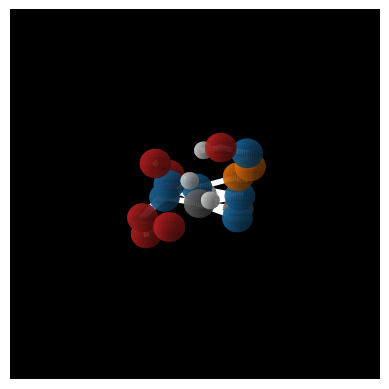

In [41]:
visualize(path = join(args.model_path, 'eval/mols10/num1000/'), dataset_info = dataset_info, max_num=1, spheres_3d=True, plot_inline = True)

#### Putting all images together

We can combine all images into a gif to see the diffusion process in action

In [42]:
path = repsol_path + '/outputs/edm_qm9/eval/mols10/'
files = os.listdir(path)
files.reverse()
save_path = [path+x for x in files]

In [43]:
# Check the path for the images saved
save_path[1:]

['/content/repsol-ml4md/outputs/edm_qm9/eval/mols10/molecule_stable_009.png',
 '/content/repsol-ml4md/outputs/edm_qm9/eval/mols10/molecule_stable_008.png',
 '/content/repsol-ml4md/outputs/edm_qm9/eval/mols10/molecule_stable_007.png',
 '/content/repsol-ml4md/outputs/edm_qm9/eval/mols10/molecule_stable_006.png',
 '/content/repsol-ml4md/outputs/edm_qm9/eval/mols10/molecule_stable_005.png',
 '/content/repsol-ml4md/outputs/edm_qm9/eval/mols10/molecule_stable_004.png',
 '/content/repsol-ml4md/outputs/edm_qm9/eval/mols10/molecule_stable_003.png',
 '/content/repsol-ml4md/outputs/edm_qm9/eval/mols10/molecule_stable_002.png',
 '/content/repsol-ml4md/outputs/edm_qm9/eval/mols10/molecule_stable_001.png',
 '/content/repsol-ml4md/outputs/edm_qm9/eval/mols10/molecule_stable_000.png',
 '/content/repsol-ml4md/outputs/edm_qm9/eval/mols10/molecule_stable_009.txt',
 '/content/repsol-ml4md/outputs/edm_qm9/eval/mols10/molecule_stable_008.txt',
 '/content/repsol-ml4md/outputs/edm_qm9/eval/mols10/molecule_sta

Put it all together and generate the gif

In [44]:
imgs = [imageio.imread(fn) for fn in save_path[1:(int((len(save_path) -1) / 2))]]
gif_path = generative_model_path + '/output.gif'
print(f'Creating gif with {len(imgs)} images')

# Add the last frame 10 times so that the final result remains temporally.
imgs.extend([imgs[-1]] * 20)
imageio.mimsave(gif_path, imgs, subrectangles=True)

<ipython-input-44-b7cc5b8f65b8>:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  imgs = [imageio.imread(fn) for fn in save_path[1:(int((len(save_path) -1) / 2))]]


Creating gif with 9 images


<img src = 'https://drive.google.com/uc?id=1-9y_fZJk7PAKXuT4psJvd1s7OWGX5lxH'>

A more thorough exploration of the diffusion process may lead to this kind of visualization:

<img src = 'https://drive.google.com/uc?id=1Ddtw6KavnMLPmjvmDa9akt9h6EmFIGKu'>

We have loaded one of the models pre-trained originally. However, we can construct our own model, training a network in our own database of molecules and then employ it to generate molecules that try to optimize a given property. This is a more involved process than with some other methods, but is worth taking a look further if you are interested in similar models.